In [1]:
import pandas as pd 
import numpy as np 
import pickle 
from sklearn.metrics import accuracy_score 

In [6]:
## Load the sigmoid model 
sigmoid = pickle.load(open('sigmoid_model.sav', 'rb')) 

## Load in the data 
## Read in csv 
df = pd.read_csv('model_data.csv', 
                                index_col = ['year', 'ID']).dropna()

## Test and train split for time series
train = df.head(
    int(df.shape[0] * 0.8 ) 
) 

test = df.tail(
    int(df.shape[0] * 0.2) 
)

## Split into x and y 
def SplitData(df): 
    y = df.lead_rating 
    x = df.drop('lead_rating', axis = 1) 
    
    return x, y 

train_x, train_y = SplitData(train) 
test_x, test_y = SplitData(test) 

## Look at the initial model accuracy 
print(
    accuracy_score(sigmoid.predict(test_x), test_y) 
)
print(df.shape) 
print(df.columns) 

0.6906077348066298
(1813, 13)
Index(['lead_rating', 'rating', 'IQ_TOTAL_ASSETS', 'IQ_TOTAL_REV', 'IQ_NI_CF',
       'IQ_AR', 'IQ_GP ', 'IQ_AP', 'IQ_TOTAL_LIAB', 'IQ_TOTAL_DEBT',
       'IQ_CASH_FINAN', 'IQ_TOTAL_EQUITY', 'IQ_CASH_EQUIV'],
      dtype='object')


We can see there are 13 columns 

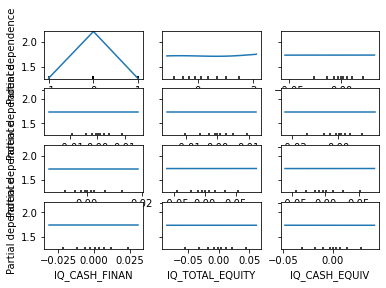

In [8]:
from sklearn.inspection import plot_partial_dependence 
plot_partial_dependence(sigmoid, test_x, test_x.columns, target = 0) 

In [9]:
plot_partial_dependence(sigmoid, test_x, test_x.columns, target = 0) 

Index(['rating', 'IQ_TOTAL_ASSETS', 'IQ_TOTAL_REV', 'IQ_NI_CF', 'IQ_AR',
       'IQ_GP ', 'IQ_AP', 'IQ_TOTAL_LIAB', 'IQ_TOTAL_DEBT', 'IQ_CASH_FINAN',
       'IQ_TOTAL_EQUITY', 'IQ_CASH_EQUIV'],
      dtype='object')